# Cross sectional images to contours

This notebook takes cross sectional images and process them to produce lists of segments compatible with the EV model

In [2]:
import numpy as np
from imageio import imread
from skimage.transform import rescale
from skimage import measure
import pickle

import matplotlib.pyplot as plt
from matplotlib import collections as mc
%matplotlib inline
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#from utilities.geometry import Plane, middle_point, two_points_normals_2d, project_point_on_direction, distance
from ev_model.utilities import geometry as evmetry
#from evmetry import Plane, middle_point, two_points_normals_2d, project_point_on_direction, distance

In [3]:
def pixels_to_um(x):
    return x * (100 / 48)

def pixels_to_mm(x):
    return pixels_to_um(x)/1000

def pixels_to_cm(x):
    return pixels_to_mm(x)/10

scale = 100/48
pixels_to_um(2500)

5208.333333333334

In [4]:
def plot_normal(p1, p2, mp, symbol, normal):
    new_p = evmetry.project_point_on_direction(direction=normal, source=mp)
    plt.plot([mp[0],new_p[0]], [mp[1],new_p[1]], symbol)

In [5]:
def find_contours_in_foreground(img, img_upscaled, foreground, save=True, show=True, min_perimeter = 90):
    contours = measure.find_contours(foreground, 0.8)

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[20,10])
    
    greater_than_N = []

    # show image
    ax1.set_title('Oviduct cross-section (original size)')
    ax1.imshow(img)
    ax1.set_aspect('equal')
    
    ax2.set_title('Identified contours (upscaled image)')
    ax2.set_aspect('equal')
    ax1.axis([0, img.shape[1], 0, img.shape[0]])
    ax2.axis([0, img_upscaled.shape[1], 0, img_upscaled.shape[0]])
    ax2.imshow(img_upscaled, interpolation='nearest', cmap=plt.cm.gray)

    for n, contour in enumerate(contours):
        ring = LinearRing(contour)
        if ring.length >= min_perimeter:
            greater_than_N.append(n)
            ax2.plot(contour[:,1], contour[:,0], linewidth=2, color='orange')

    fontprops = fm.FontProperties(size=12)
    scalebar1 = AnchoredSizeBar(ax1.transData,
                               48, '100 um', 'lower right', 
                               pad=0.1,
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)
    scalebar2 = AnchoredSizeBar(ax2.transData,
                               100, '100 um', 'lower right', 
                               pad=0.1,
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)

    ax2.add_artist(scalebar2)
    ax1.add_artist(scalebar1)
    if save:
        fig.savefig('01_ampulla_cross_section_and_identified_contours_'+base_filename+'.png', bbox_inches='tight', dpi=300)
    elif show:        
        fig.showfig()

    return contours, greater_than_N

In [10]:
def simplify_contours(contours, greater_than_N, avg_cell_diameter, tolerance, scale = 1.0):
    selected_simplified_contours = []
    polygons = []

    total_perimeter = 0.
    secretory_cells_fitted = 0.
    ciliary_cells_fitted = 0.
    total_vertices = 0.
    total_area = 0.

    for i in range(len(greater_than_N)):
        contour = measure.approximate_polygon(contours[greater_than_N[i]], tolerance)
        # scale the contours here
        contour *= scale
        selected_simplified_contours.append(contour)
        
        polygon = Polygon(contour)
        polygons.append(polygon)

        total_perimeter += polygon.length
        total_vertices += contour.shape[0]
        total_area += polygon.area

        for j in range(contour.shape[0]-1):
            d = evmetry.two_points_distance(contour[j], contour[j+1])
            #print(f'edge d:{d} would fit {int(d / avg_cell_diameter)} secretory cells')
            if d >= avg_cell_diameter:
                # generate n secretory cells in this edge
                # 1 compute the edge normal
                # 2 subsection
                secretory_cells_fitted += int(d / avg_cell_diameter)
            else:
                # generate a ciliary cell patch here
                ciliary_cells_fitted += 1
    print(f'|{tolerance}|{total_vertices}|{total_perimeter:.2f}|{total_area:,.2f}|{secretory_cells_fitted}|{ciliary_cells_fitted}|-> total:{secretory_cells_fitted+ciliary_cells_fitted}')
    return selected_simplified_contours, polygons

In [7]:
# Display the specified edge/shape
def display_edge_with_normals(polygons, avg_cell_diameter, i=0):
    e_coords = np.array(polygons[i].exterior.coords)
    fig, ax = plt.subplots(1, 1, sharex='col',figsize=[80,40])
    # plt.figure()
    for idx in range(len(e_coords) - 1):
        p1 = e_coords[idx]
        p2 = e_coords[idx + 1]
        normal = evmetry.two_points_normals_2d(p1, p2)[0] # [0 if i in inside_another else 1]

        d = evmetry.distance(p1, p2)
        if d >= avg_cell_diameter:
            source_p = p1
            n = d // avg_cell_diameter
            # print(f'edge {idx} d:{d:.3f} sub-sections:{n}')
            p1p2 = p2 - p1
            if n >= 2:
                # fin n full size cells
                step = 1./n
                for st in range(int(n)):
                    dest_p = evmetry.project_point_on_direction(source=source_p, direction = p1p2, dist=step)
                    mp = evmetry.middle_point(source_p, dest_p)
                    plot_normal(source_p, dest_p, mp, '-g', normal)
                    # the edge
                    plt.plot([source_p[0], dest_p[0]], [source_p[1], dest_p[1]], '-.')
                    source_p = dest_p
            else:
                # fit one full size cell
                extra = d - avg_cell_diameter
                dest_p = evmetry.project_point_on_direction(source=source_p, direction = p1p2, dist=1./d * avg_cell_diameter)
                plt.plot([source_p[0], dest_p[0]], [source_p[1], dest_p[1]], '--')
                mp = evmetry.middle_point(source_p, dest_p)
                plot_normal(source_p, dest_p, mp, '--b', normal)
                source_p = dest_p
                # fit one partial size cell
                plt.plot([source_p[0],p2[0]], [source_p[1],p2[1]], '-k')  
                mp = evmetry.middle_point(source_p, p2)
                plot_normal(source_p, p2, mp, '--b', normal)

        else:
            # the normal
            mp = evmetry.middle_point(p1, p2)
            plot_normal(p1, p2, mp, '-b', normal)
            # the edge
            plt.plot([p1[0],p2[0]], [p1[1],p2[1]], '-y')

    fontprops = fm.FontProperties(size=12)
    scalebar = AnchoredSizeBar(ax.transData,
                               22.5, '50 um', 'lower left', 
                               pad=0.1,
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)

    ax.add_artist(scalebar)

# Ampulla

In [7]:
base_filename = '3-1to3-5_L2-3_tr-amp_2'

img = imread('./img/'+base_filename+'.png')

# scale the image to make 1 pixel = 1 um
img_upscaled = rescale(img, scale, anti_aliasing = True, multichannel=True, mode='constant')
# get the foreground
# foreground = img[:,:,3] != 0 & img[:,:,1] > 240
foreground = (img_upscaled[:,:,3] > 0.2) & (img_upscaled[:,:,1] > 0.7)

Because pixels are single and independent representations of colour we need to process them to obtain some useful geometrical information. This is done firstly by using [`skimage.measure.find-contours`](http://scikit-image.org/docs/0.14.x/api/skimage.measure.html#find-contours) to identify their contours. 

Then, these contours are converted into geometrical shapes using the [`shapely`](https://github.com/Toblerity/Shapely) package.  

We can now proceed to check and display those having a perimeter $\ge$ 20 pixels.

A total of 180 contours were identified. From these, 13 have a perimeter of at least 200 pixels.


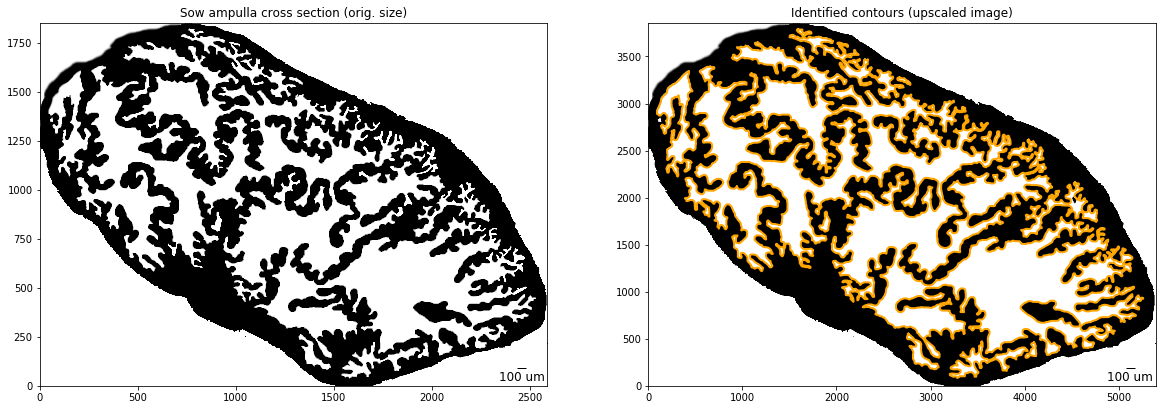

In [7]:
min_perimeter = 200
contours, greater_than_N = find_contours_in_foreground(img, img_upscaled, foreground, save = False, show = False, min_perimeter=min_perimeter)
# how many contours were found?, how many of them have more than N edges, and what are those?
print(f'A total of {len(contours)} contours were identified. From these, {len(greater_than_N)} have a perimeter of at least {min_perimeter} pixels.')

These will be further processed in the following steps to obtain the physical limits of the model. 

## EV potential starting point coordinates

Given that the extra cellular vesicles are produced by the oviduct epitheluim, the edges of the identified contours provide the vesicle's initial coordinates and the hypothetical locations of the source points producing the vesicles of our interest.


### Number of cells per edge

The manner in which the number of cells per edge was decided changed after each iteration of the modelling activity. Here,  a brief description of the major changes is presented.  

#### v1
Took the middle point between each pair of vertices on the polygon as a source point. The source points and the oviduct boundaries were independent concepts. Both were loaded as separate binary files, one was targetting the visual representation in visualisation, the other was purely oriented to collision detection.  
#### v2
The second version performed fixed-lenght subdivision of the poligon edges. If edgeLenght > 0.7 subdivide each edge in 6 parts, each part became a source point. Still source points and boundaries were independent concepts. Two binary files were still required.  
#### v3 (current)
After consulting with Dr Paul Richmond on the performance issues observed in our previous models, the number of checks for collisions was flagged as the main need for optimisation. It was sugested to change the logical representation of the boundaries from a list of line segments and turn them into agents. Then, instead of checking every vesicle agent for possible collisions against every segment in the boundaries, only those within the possible displacement range would be checked.

Such approach was estimated to require extensive modification to our model yet it would also enable exploring modelling other biological concepts observed in real cells. One of such concepts is the variations in cell distribution at different sections of the oviduct, which interestingly is also reported to change in close relation with the ovulation cycle. 

Therefore, after the changes were implemented, the new cell agents introduced in our model represent the phisical boundaries of the oviduct as obtained from the histology images but they also enable representing different types of cells with distinct behaviour.

Firstly, for the number of cells in a given edge, each edge is subdivided by an average oviductal cell diameter of $5 \mu m$ [x]. Then, in order to represent an average cell distributions of 50/50 ciliary/secretory [xx] at the ampulla, the fate of each cell is decided by sampling from an normally distributed random number generator (RNG). The cell will be ciliary if randomNumber &lt; 0.5 or secretory otherwise.  

Allocating the hypothetical cells on the edges.

### Shape simplification 
Due to the high complexity of the contour, most of the original edges have shorter length than the avg cells size. This works against our cell placement purposes. A solution for this is to simplify the shapes using less vertices. To do so, we use [`skimage.measure.approximate-polygon`](http://scikit-image.org/docs/0.14.x/api/skimage.measure.html#approximate-polygon).

After testing with different values for the tolerance it was decided to use the value of 0.1 because the perimeter obtained is the most similar to the original and the number of smaller-sized cells is the second highest. Both factors would enable reproducing the distributions described by [x]

| Tolerance | Vertices | Perimeter | Area | Avg sized cells | Smaller sized cells | Total cells |
| - | - | - | - | - | - | - |
|0.0|160191.0|134245.78|5920991.54|0.0|160178.0|160178.0|
|0.1|48279.0|134245.78|5920991.54|12266.0|42628.0|54894.0|
|0.2|47662.0|134203.90|5920874.80|12266.0|42011.0|54277.0|
|0.25|47662.0|134203.90|5920874.80|12266.0|42011.0|54277.0|
|0.3|42507.0|133629.29|5920874.60|12284.0|36840.0|49124.0|
|0.35|36139.0|132870.98|5920844.70|13089.0|29736.0|42825.0|
|0.4|32930.0|132500.35|5920915.50|14396.0|25419.0|39815.0|
|0.5|24055.0|131229.79|5920731.10|16094.0|15371.0|31465.0|
|1.0|11035.0|129118.04|5919710.00|23157.0|1491.0|24648.0|  

*note:* Average-sized-cells = $\sum$int(edge lenght/avg cell size), Avg cell size= ($\phi \approx 5\mu m$), Small cell size = ($\phi \lt 5\mu m$)

In [27]:
# (OPTIONAL STEP) compare the cells fitted in the simplified contours
#tolerances = [0.0, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 1.0]
#avg_cell_diameter = 4.5
#contours, greater_than_N, avg_cell_diameter
#for tolerance in tolerances:
#    simplify_contours(contours, greater_than_N, avg_cell_diameter, tolerance)

In [28]:
# simplify the contours without comparison
avg_cell_diameter = 4.5
simplified_contours, polygons = simplify_contours(contours, greater_than_N, avg_cell_diameter, 0.1)

|0.1|48279.0|134245.78|5,920,991.54|12266.0|42628.0|-> total:54894.0


## Polygons export

The polygons must be exported to be used in the next steps of the pipeline.

For persistency, the Shapely polygons can be dumped to disk using the pickle module. Later, the same objects can be loaded without losing any information.

In [29]:
# EXPORT THE POLYGONS COMPUTED
with open('./img/polygons_'+base_filename+'.pickle', 'wb') as pickle_target:
    pickle.dump(polygons, pickle_target) # what, where

In the biological process under scrutiny, the EVs are released from the oviduct wall and their initial displacement is to the inside of the tube. To capture this in our model, we need to define an initial direction for every source point. This direction will be directly dependant on the spatial characteristics of each shape. 

### (Optional) Visualise the source point directions
Our source point generation algorithm depends on the computed normal for each edge to provide the initial direction in which the EVs will displace. Because the polygons generated are described following the Right Hand Coordinate System ([RHS](http://www.ntu.edu.sg/home/ehchua/programming/opengl/CG_BasicsTheory.html)) or Counter-Clockwise ([CCW](https://shapely.readthedocs.io/en/latest/manual.html#shapely.geometry.polygon.orient)) direction, weu


In [ ]:
# optional step
display_edge_with_normals(polygons, avg_cell_diameter=4.5, i=1)

# UTJ  

We do the full pipeline for the Utero-tubal junction here.

A total of 205 contours were identified. From these, 8 have a perimeter of at least 200 pixels.
|0.1|5761.0|14853.91|119,619.64|1304.0|4868.0|-> total:6172.0


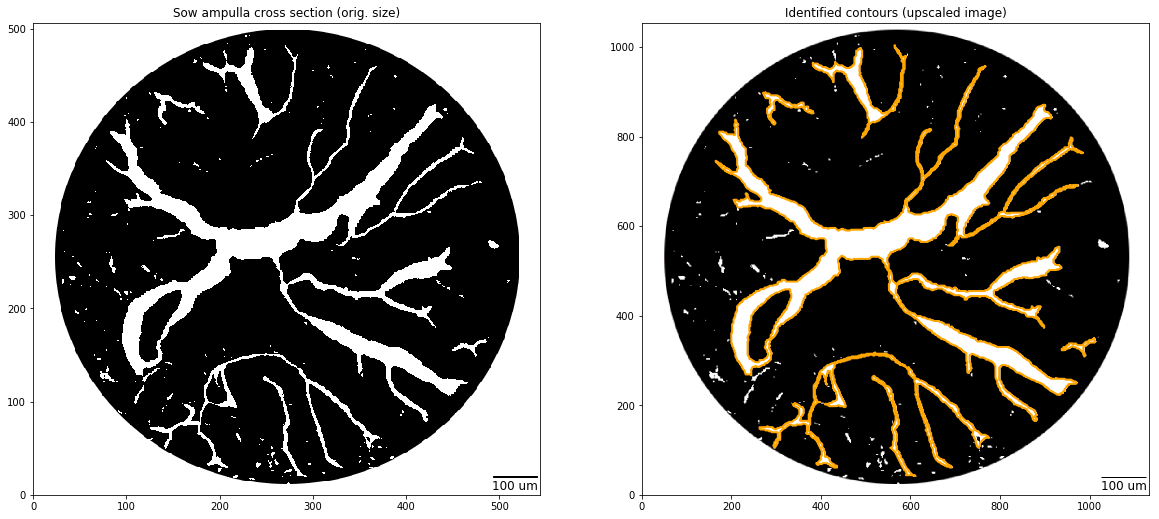

In [8]:
base_filename = '3-1to3-5_L2-3_bl-utj'

# load the actual file
img = imread('./img/'+base_filename+'.png')

# scale the image to make 1 pixel = 1 um
img_upscaled = rescale(img, scale, anti_aliasing = True, multichannel=True, mode='constant')
# get the foreground
# foreground = img[:,:,3] != 0 & img[:,:,1] > 240
foreground = (img_upscaled[:,:,3] > 0.2) & (img_upscaled[:,:,1] > 0.7)

min_perimeter = 200
contours, greater_than_N = find_contours_in_foreground(img, img_upscaled, foreground, save = False, show = False, min_perimeter=min_perimeter)
# how many contours were found?, how many of them have more than N edges, and what are those?
print(f'A total of {len(contours)} contours were identified. From these, {len(greater_than_N)} have a perimeter of at least {min_perimeter} pixels.')

# simplify the contours without comparison
avg_cell_diameter = 4.5
simplified_contours, polygons = simplify_contours(contours, greater_than_N, avg_cell_diameter, 0.1)

# EXPORT THE POLYGONS COMPUTED
with open('./img/polygons_'+base_filename+'.pickle', 'wb') as pickle_target:
    pickle.dump(polygons, pickle_target) # what, where

# Isthmus

A total of 136 contours were identified. From these, 1 have a perimeter of at least 200 pixels.
|0.1|3659.0|9594.29|45,817.78|878.0|3147.0|-> total:4025.0


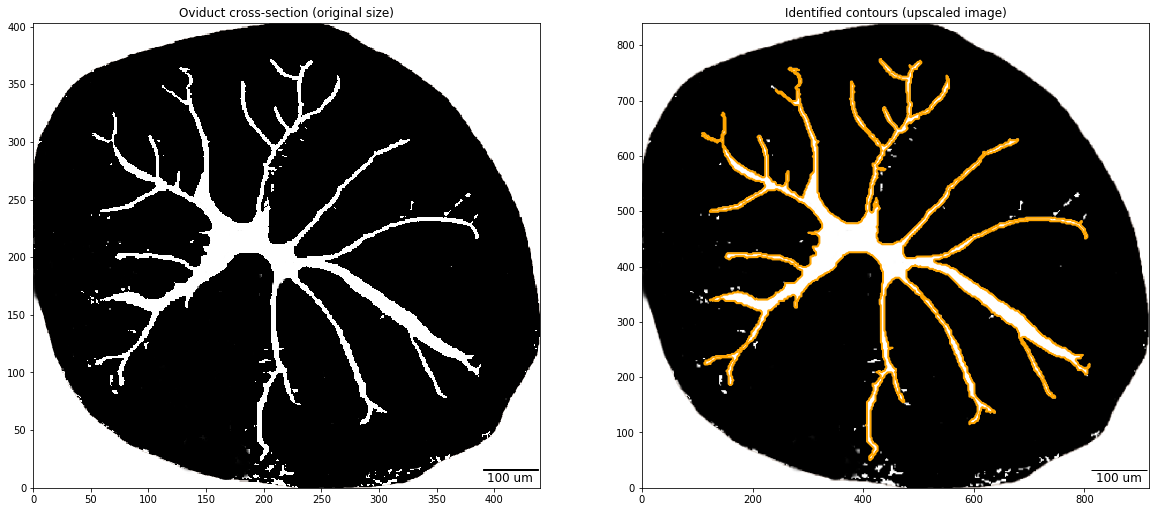

In [12]:
base_filename = '3-1to3-5_L2-3_tl-isth_fixed'

# load the actual file
img = imread('./resources/img/'+base_filename+'.png')

# scale the image to make 1 pixel = 1 um
img_upscaled = rescale(img, scale, anti_aliasing = True, multichannel=True, mode='constant')
# get the foreground
# foreground = img[:,:,3] != 0 & img[:,:,1] > 240
foreground = (img_upscaled[:,:,3] > 0.2) & (img_upscaled[:,:,1] > 0.7)

min_perimeter = 200
contours, greater_than_N = find_contours_in_foreground(img, img_upscaled, foreground, save = False, show = False, min_perimeter=min_perimeter)
# how many contours were found?, how many of them have more than N edges, and what are those?
print(f'A total of {len(contours)} contours were identified. From these, {len(greater_than_N)} have a perimeter of at least {min_perimeter} pixels.')

# simplify the contours without comparison
avg_cell_diameter = 4.5
simplified_contours, polygons = simplify_contours(contours, greater_than_N, avg_cell_diameter, 0.1)

# EXPORT THE POLYGONS COMPUTED
with open('./resources/img/polygons_'+base_filename+'.pickle', 'wb') as pickle_target:
    pickle.dump(polygons, pickle_target) # what, where

# Isthmus-Ampulla junction

A total of 461 contours were identified. From these, 20 have a perimeter of at least 200 pixels.
|0.1|25900.0|66745.64|809,645.20|5816.0|22012.0|-> total:27828.0


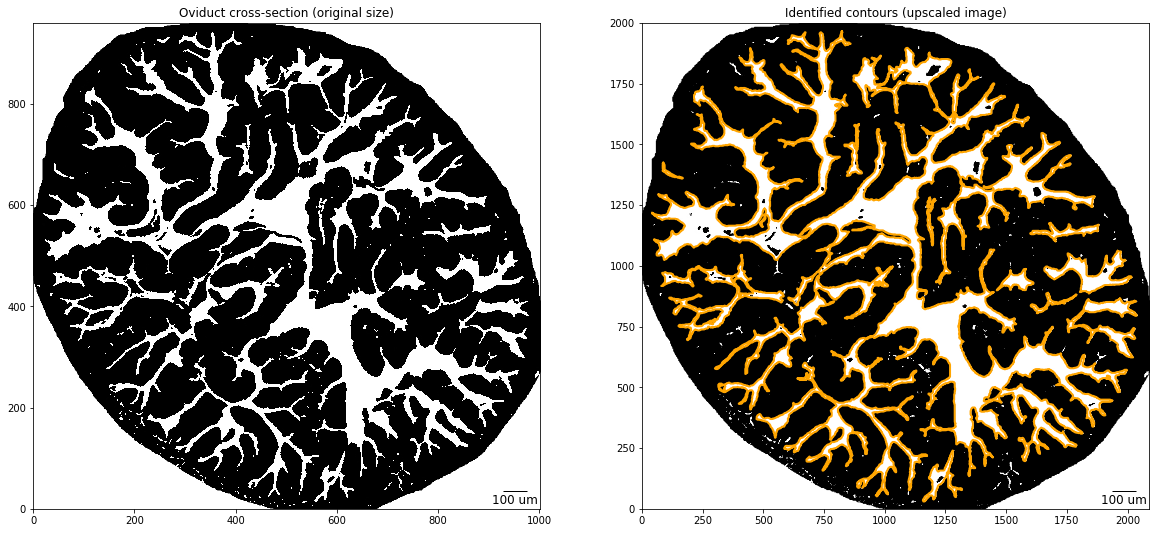

In [13]:
base_filename = '3-1to3-5_L2-3_c'

# load the actual file
img = imread('./img/'+base_filename+'.png')

# scale the image to make 1 pixel = 1 um
img_upscaled = rescale(img, scale, anti_aliasing = True, multichannel=True, mode='constant')
# get the foreground
# foreground = img[:,:,3] != 0 & img[:,:,1] > 240
foreground = (img_upscaled[:,:,3] > 0.2) & (img_upscaled[:,:,1] > 0.7)

min_perimeter = 200
contours, greater_than_N = find_contours_in_foreground(img, img_upscaled, foreground, save = False, show = False, min_perimeter=min_perimeter)
# how many contours were found?, how many of them have more than N edges, and what are those?
print(f'A total of {len(contours)} contours were identified. From these, {len(greater_than_N)} have a perimeter of at least {min_perimeter} pixels.')

# simplify the contours without comparison
avg_cell_diameter = 4.5
simplified_contours, polygons = simplify_contours(contours, greater_than_N, avg_cell_diameter, 0.1)

# EXPORT THE POLYGONS COMPUTED
with open('./img/polygons_'+base_filename+'.pickle', 'wb') as pickle_target:
    pickle.dump(polygons, pickle_target) # what, where

# Infundibulum

A total of 649 contours were identified. From these, 47 have a perimeter of at least 200 pixels.
|0.1|36501.0|95127.37|1,453,926.26|8333.0|30847.0|-> total:39180.0


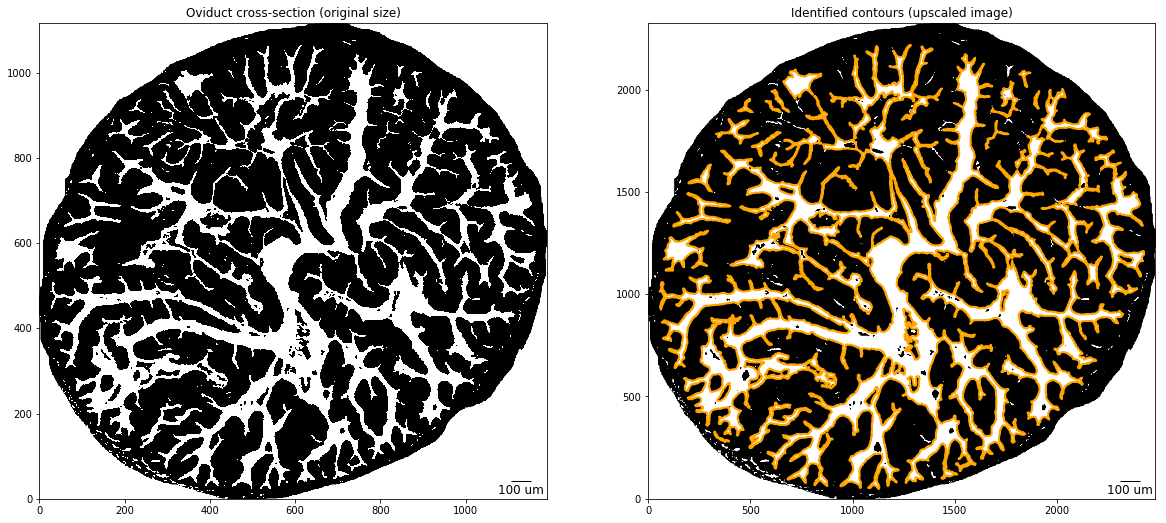

In [14]:
base_filename = '3-1to3-5_L2-3_br-inf'

# load the actual file
img = imread('./img/'+base_filename+'.png')

# scale the image to make 1 pixel = 1 um
img_upscaled = rescale(img, scale, anti_aliasing = True, multichannel=True, mode='constant')
# get the foreground
# foreground = img[:,:,3] != 0 & img[:,:,1] > 240
foreground = (img_upscaled[:,:,3] > 0.2) & (img_upscaled[:,:,1] > 0.7)

min_perimeter = 200
contours, greater_than_N = find_contours_in_foreground(img, img_upscaled, foreground, save = False, show = False, min_perimeter=min_perimeter)
# how many contours were found?, how many of them have more than N edges, and what are those?
print(f'A total of {len(contours)} contours were identified. From these, {len(greater_than_N)} have a perimeter of at least {min_perimeter} pixels.')

# simplify the contours without comparison
avg_cell_diameter = 4.5
simplified_contours, polygons = simplify_contours(contours, greater_than_N, avg_cell_diameter, 0.1)

# EXPORT THE POLYGONS COMPUTED
with open('./img/polygons_'+base_filename+'.pickle', 'wb') as pickle_target:
    pickle.dump(polygons, pickle_target) # what, where

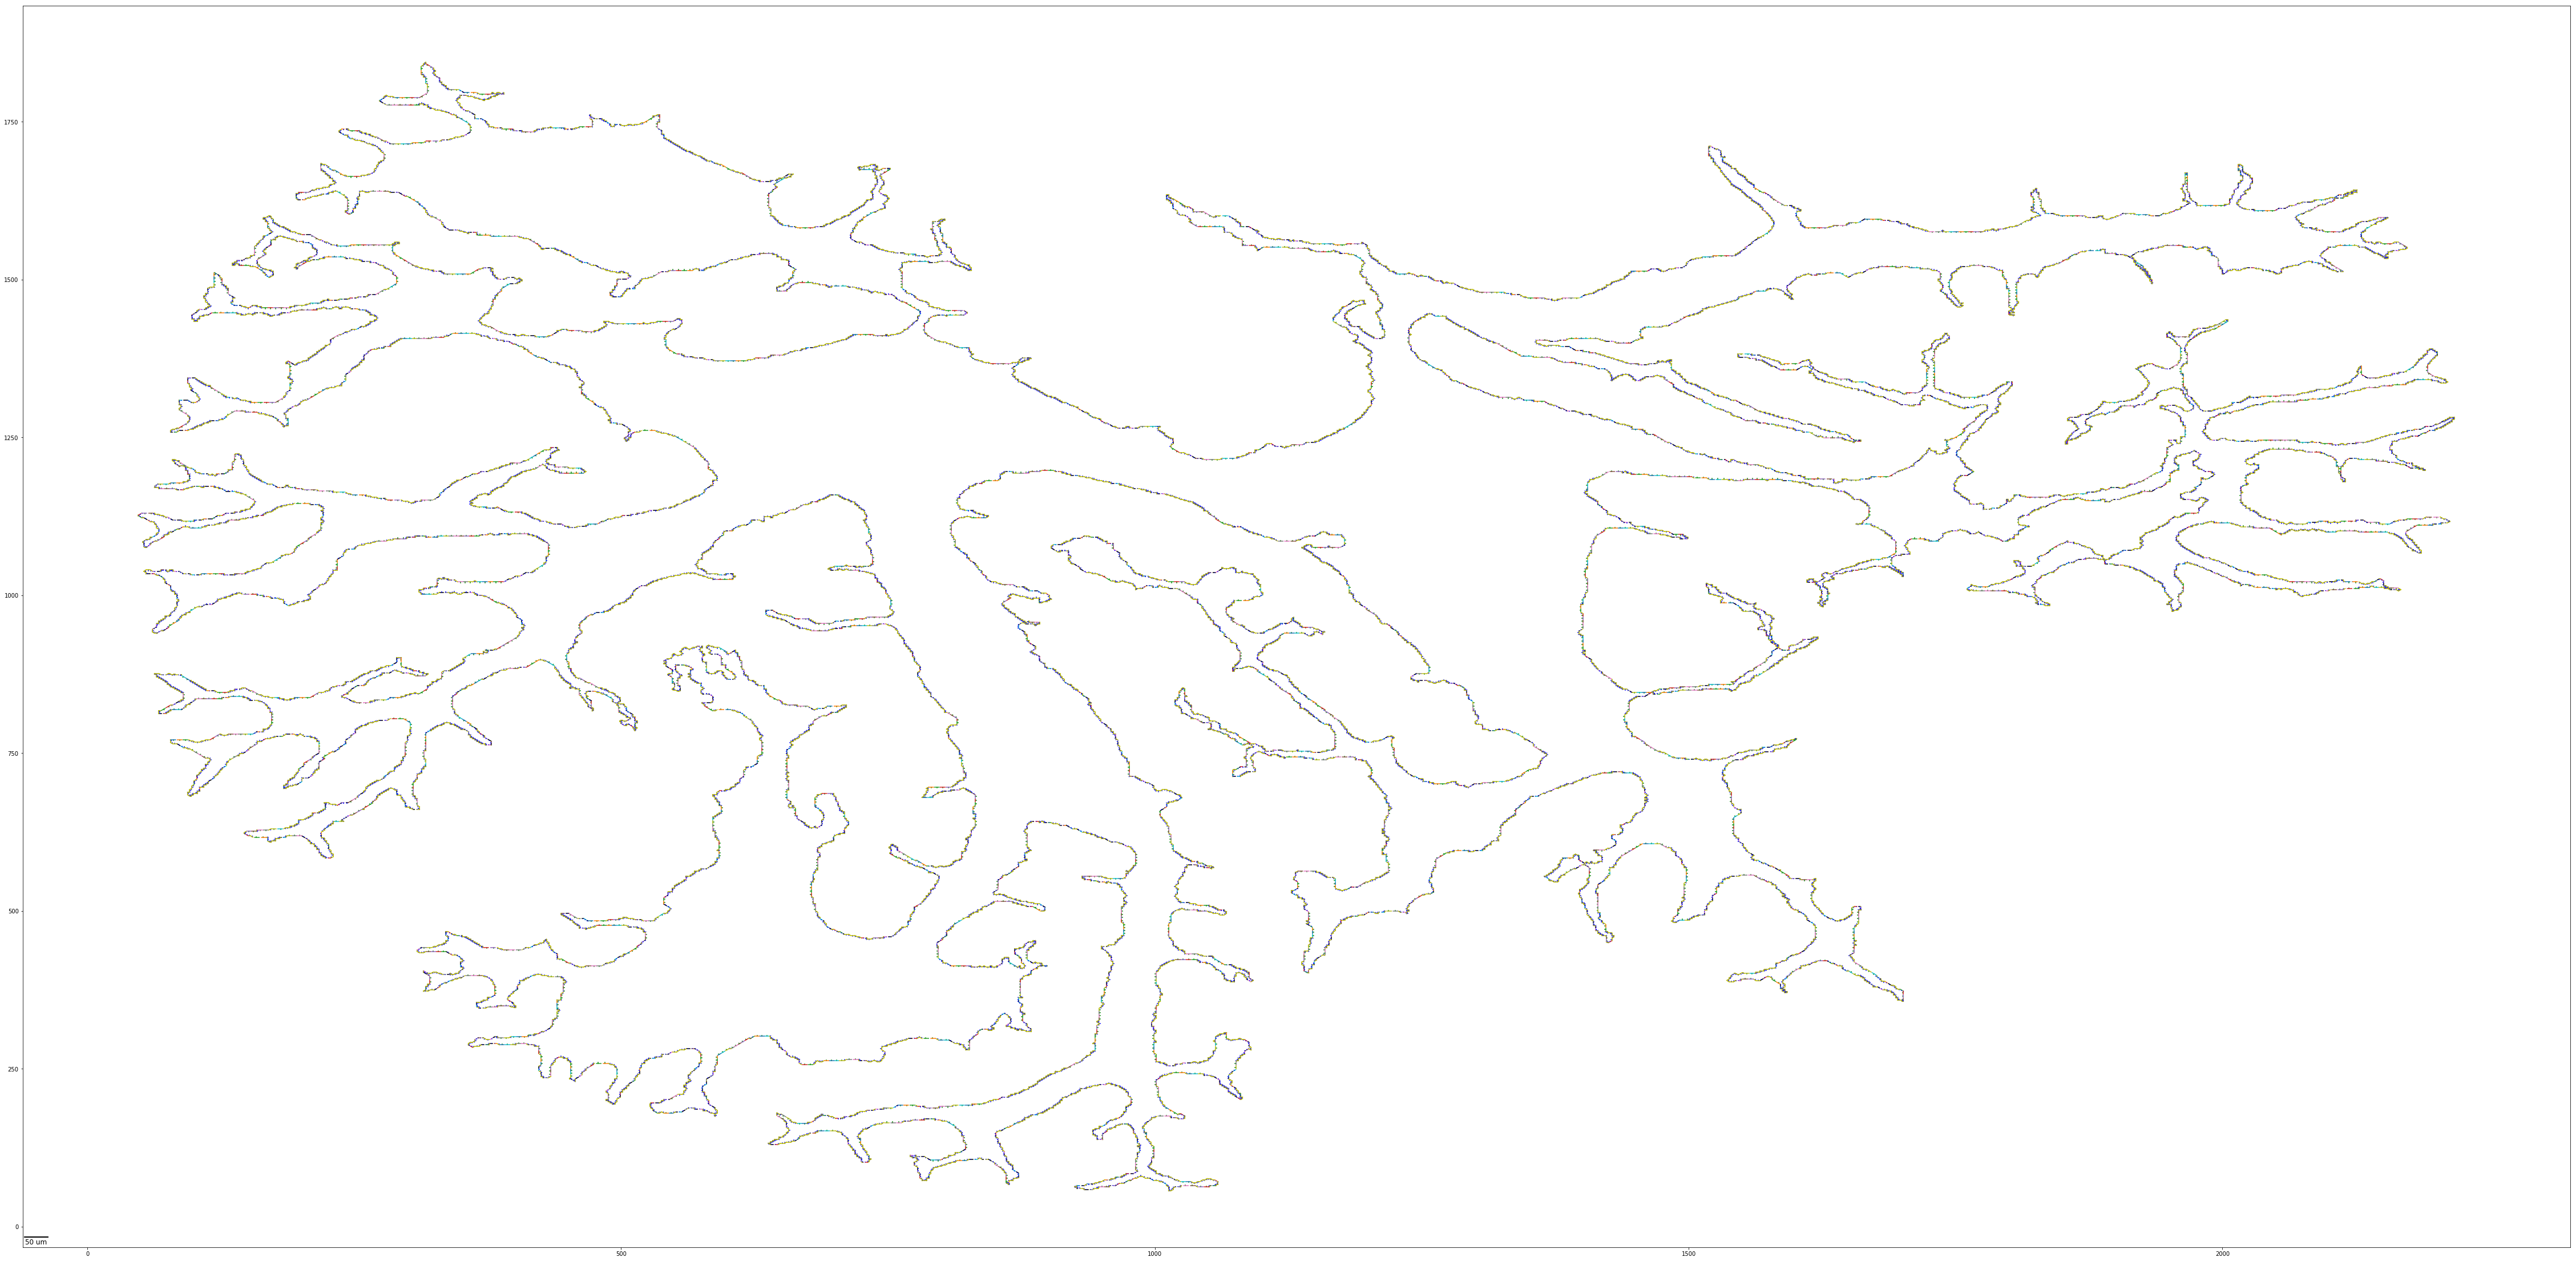

In [20]:
display_edge_with_normals(polygons, avg_cell_diameter=4.5, i=0)

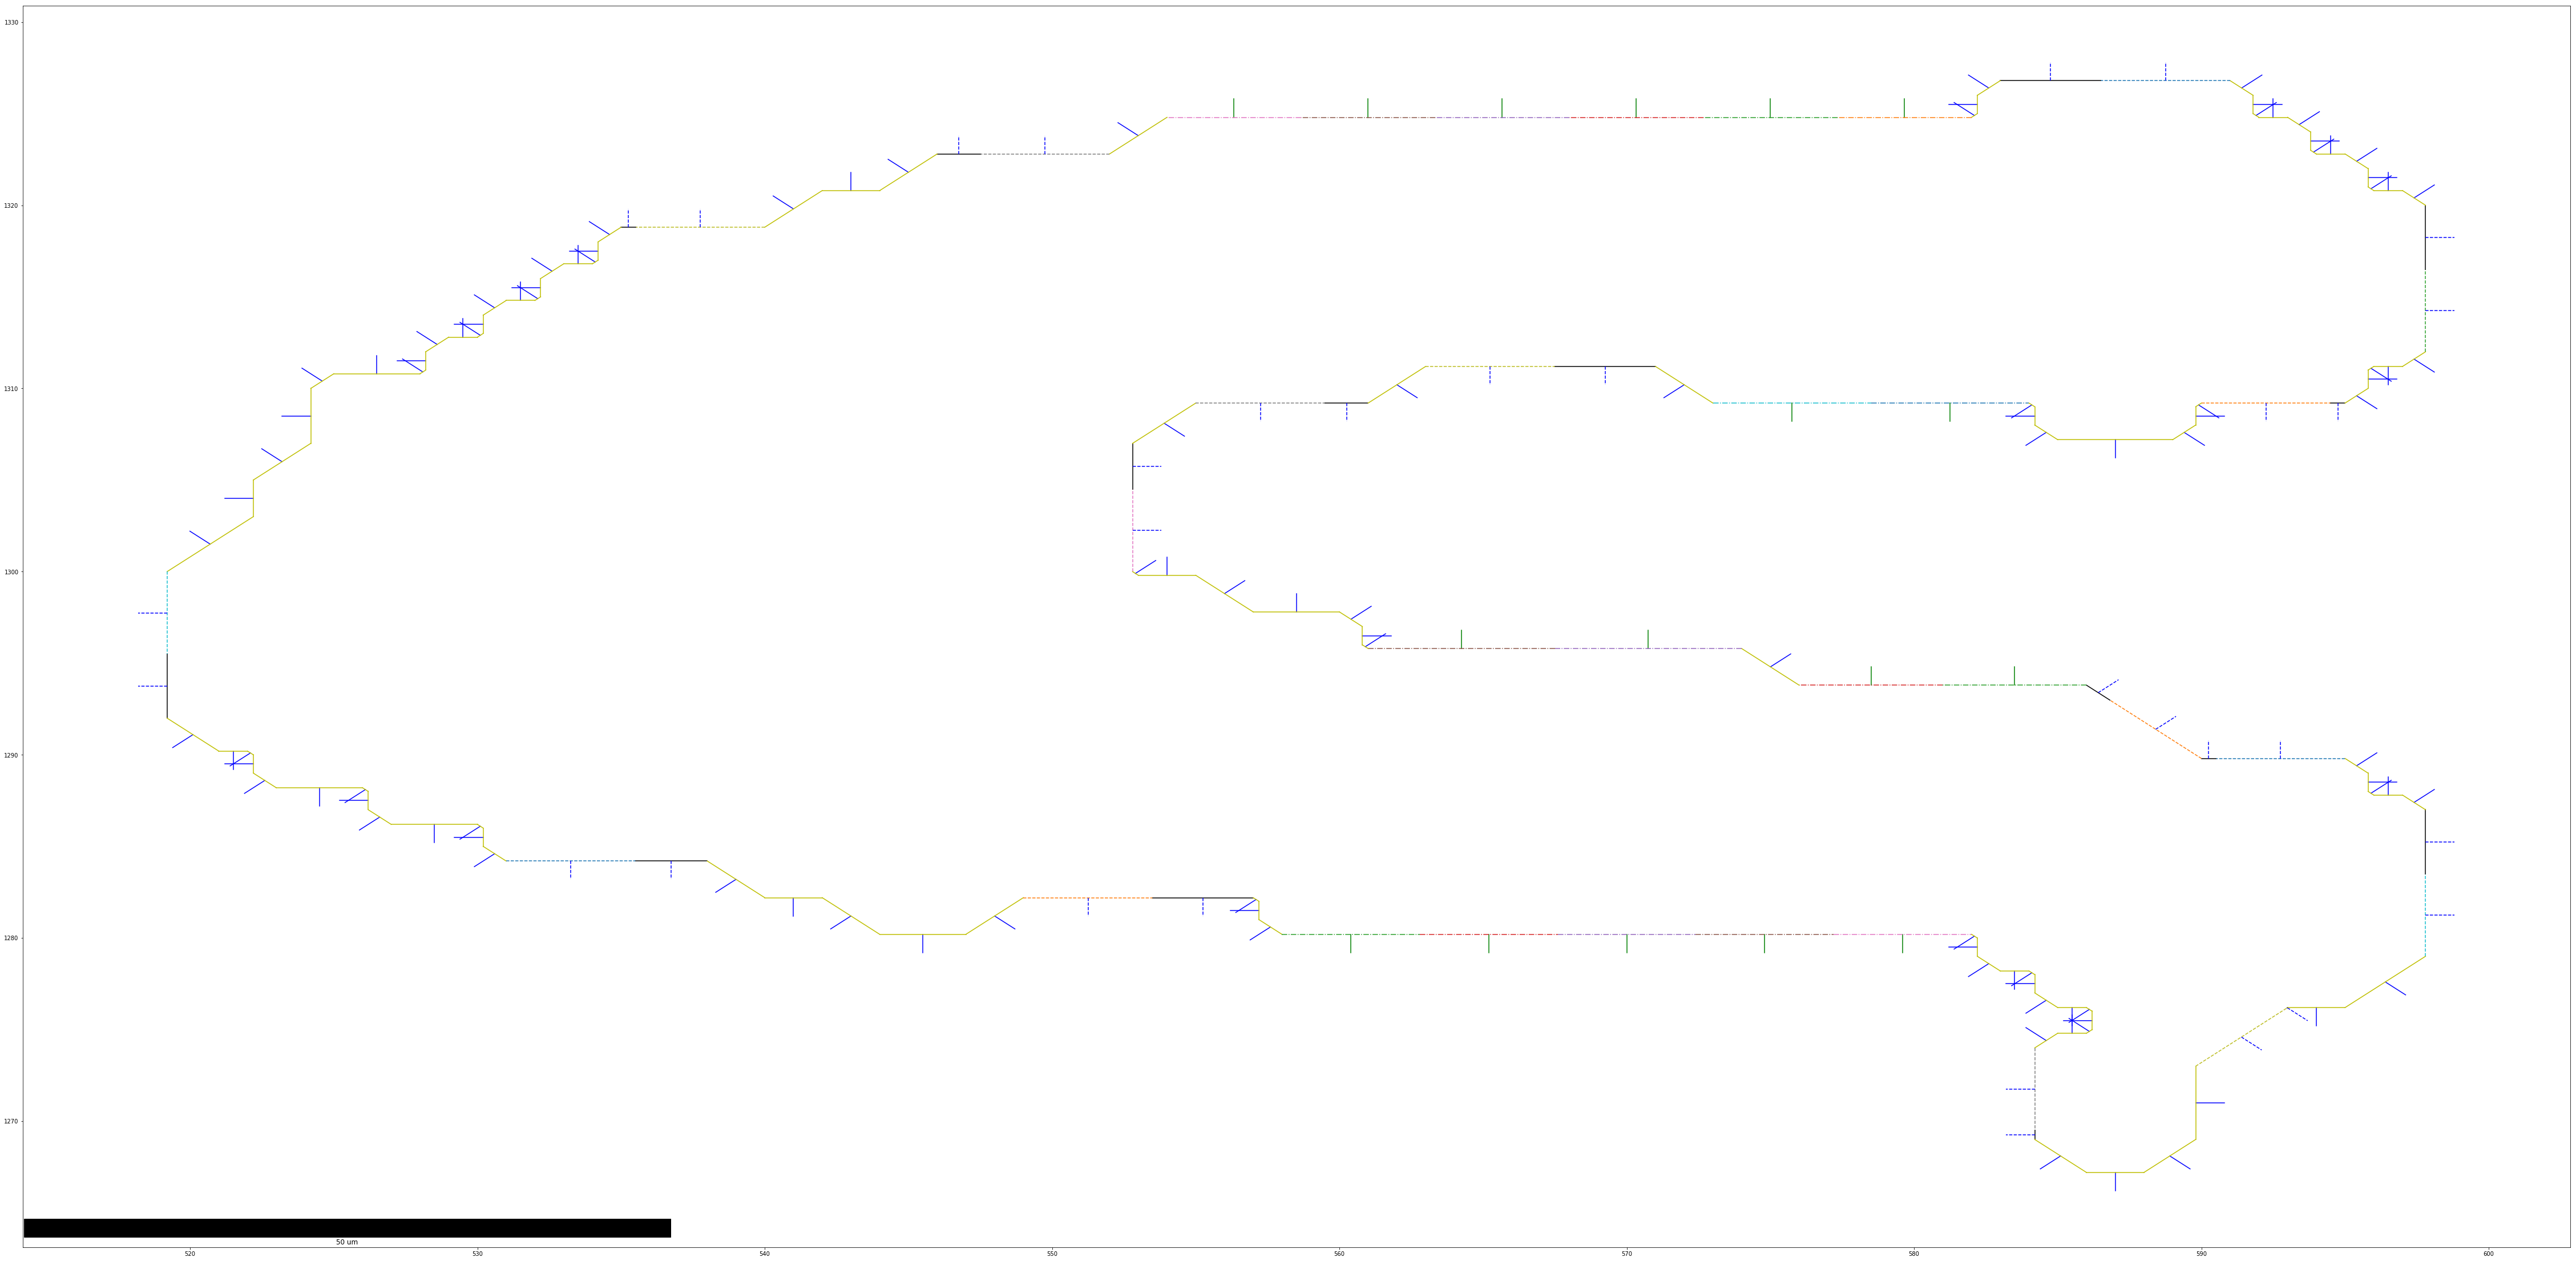

In [26]:
display_edge_with_normals(polygons, avg_cell_diameter=4.5, i=7)